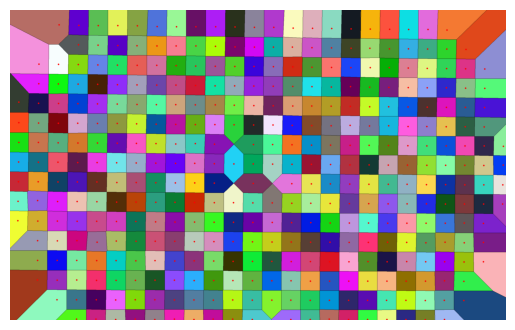

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Example: detected points (x, y)
filename = 'output/detected_points.txt'
points = pd.read_csv(filename).to_numpy()

# Create image
img = cv2.imread('sample_calibration_images/moving_target/set1/cal1.tif')
h, w, _ = img.shape

# Subdiv for Voronoi
subdiv = cv2.Subdiv2D((0, 0, w, h))
for p in points:
    subdiv.insert(p)

# Get Voronoi facets
facets, centers = subdiv.getVoronoiFacetList([])

for facet in facets:
    pts = np.array(facet, np.int32)
    cv2.fillConvexPoly(img, pts, (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
    cv2.polylines(img, [pts], True, (0, 0, 0), 1)

# Draw points
for p in points:
    center = (int(p[0]), int(p[1]))
    cv2.circle(img, center, 4, (0, 0, 255), -1)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [3]:
def is_almost_square(facet, tolerance=0.1):
    # facet: Nx2 array of points
    # tolerance: allowed relative difference between width and height
    xs = facet[:, 0]
    ys = facet[:, 1]
    width = xs.max() - xs.min()
    height = ys.max() - ys.min()
    if width == 0 or height == 0:
        return False
    ratio = min(width, height) / max(width, height)
    return ratio >= (1 - tolerance)

square_facets = tuple(f for f in facets if is_almost_square(f))

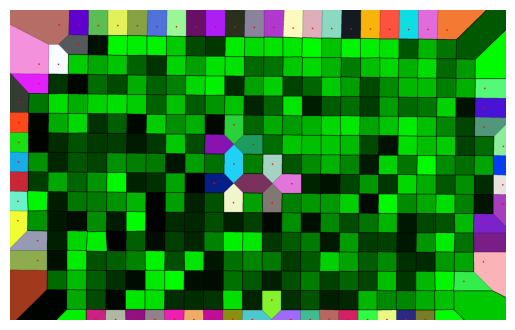

In [11]:
for i, facet in enumerate(square_facets):
    pts = np.array(facet, np.int32)
    cv2.fillConvexPoly(img, pts, (0, 255/len(square_facets)*i, 0))
    cv2.polylines(img, [pts], True, (0, 0, 0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [16]:
def facet_centroid(facet):
    # facet: Nx2 array
    return np.mean(facet, axis=0)

# Get centroids for each facet
facet_centroids = np.array([facet_centroid(f) for f in facets])

# Sort by y (bottom to top), then x (left to right)
sorted_indices = np.lexsort((facet_centroids[:, 0], -facet_centroids[:, 1]))
ordered_facets = tuple(facets[i] for i in sorted_indices)

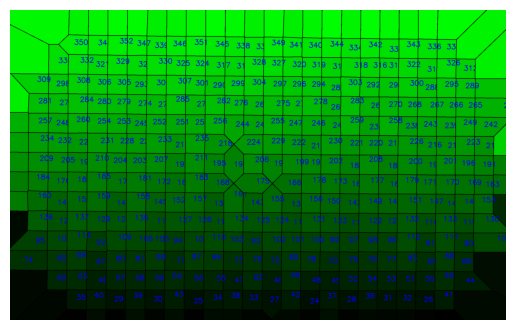

In [20]:
for i, facet in enumerate(ordered_facets):
    pts = np.array(facet, np.int32)
    cv2.fillConvexPoly(img, pts, (0, 255/len(ordered_facets)*i, 0))
    cv2.polylines(img, [pts], True, (0, 0, 0), 2)
    # Draw index number at centroid with larger font
    centroid = np.mean(pts, axis=0).astype(int)
    cv2.putText(img, str(i), tuple(centroid), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,0,0), 2, cv2.LINE_AA)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()